In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
nodes = pd.read_csv('/content/drive/MyDrive/sem 6/Linear Optimization/demand.csv', index_col = 'node')
nodes.rename(columns={"distance to depot":'d0'}, inplace = True)

In [ ]:
# read node data in coordinate (x,y) format
node_number = len(nodes.index) - 1
nodes

,d0,demand
node,,
0,0,0
1,25,4
2,43,6
3,57,5
4,43,4
5,61,7
6,29,3
7,41,5
8,48,4


In [ ]:
nodes.shape

(10, 2)

In [ ]:
# pw.index.rename('',inplace = True) # renaming to empy string , inplace is for making the changes in the original dataframe

In [ ]:
# read pairwise distance
pw = pd.read_csv('/content/drive/MyDrive/sem 6/Linear Optimization/pairwise.csv', index_col = 'Unnamed: 0') #Unnamed specify that first column value in the csv must be used as index of dataframe
pw

,1,2,3,4,5,6,7,8,9
1,0,29,34,43,68,49,66,72,91
2,29,0,52,72,96,72,81,89,114
3,34,52,0,45,71,71,95,99,108
4,43,72,45,0,27,36,65,65,65
5,68,96,71,27,0,40,66,62,46
6,49,72,71,36,40,0,31,31,43
7,66,81,95,65,66,31,0,11,46
8,72,89,99,65,62,31,11,0,36
9,91,114,108,65,46,43,46,36,0


In [ ]:
print(pw.index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


#Saving Calculation Formula
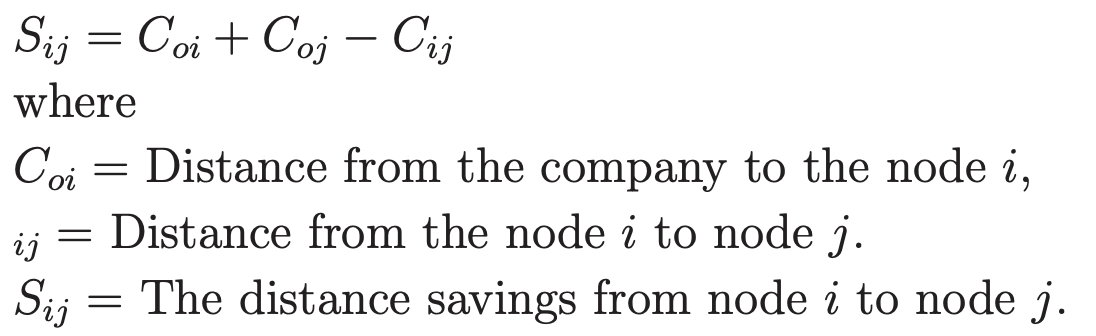

In [ ]:
# calculate savings for each link
savings = dict()
for r in pw.index:
    for c in pw.columns:
        if int(c) != int(r):
            a = max(int(r), int(c))
            b = min(int(r), int(c))
            key = '(' + str(a) + ',' + str(b) + ')'
            #print(key)
            savings[key] = nodes['d0'][int(r)] + nodes['d0'][int(c)] - pw[c][r]
            #print( nodes['d0'][int(r)],nodes['d0'][int(c)],pw[c][r])

In [ ]:
print(len(savings))
savings

36


{'(2,1)': 39,
 '(3,1)': 48,
 '(4,1)': 25,
 '(5,1)': 18,
 '(6,1)': 5,
 '(7,1)': 0,
 '(8,1)': 1,
 '(9,1)': 5,
 '(3,2)': 48,
 '(4,2)': 14,
 '(5,2)': 8,
 '(6,2)': 0,
 '(7,2)': 3,
 '(8,2)': 2,
 '(9,2)': 0,
 '(4,3)': 55,
 '(5,3)': 47,
 '(6,3)': 15,
 '(7,3)': 3,
 '(8,3)': 6,
 '(9,3)': 20,
 '(5,4)': 77,
 '(6,4)': 36,
 '(7,4)': 19,
 '(8,4)': 26,
 '(9,4)': 49,
 '(6,5)': 50,
 '(7,5)': 36,
 '(8,5)': 47,
 '(9,5)': 86,
 '(7,6)': 39,
 '(8,6)': 46,
 '(9,6)': 57,
 '(8,7)': 78,
 '(9,7)': 66,
 '(9,8)': 83}

In [ ]:
# put savings in a pandas dataframe, and sort by descending
sv = pd.DataFrame.from_dict(savings, orient = 'index') # index mean key as index for each row(use index when scaler values), column when "(1,2):[]"
sv.rename(columns = {0:'saving'}, inplace = True) #renaming the index 0 as saving
sv.sort_values(by = ['saving'], ascending = False, inplace = True)
sv.head()

,saving
"(9,5)",86
"(9,8)",83
"(8,7)",78
"(5,4)",77
"(9,7)",66


In [ ]:
# convert link string to link list to handle saving's key, i.e. str(10, 6) to (10, 6)
def get_node(link):
    link = link[1:] #remove left parenthesis
    link = link[:-1] #remove right parenthesis
    nodes = link.split(',') #split the value
    return [int(nodes[0]), int(nodes[1])] #convert to int and return

In [ ]:
# determine if a node is interior to a route
def interior(node, route):
    try:
        i = route.index(node)
        # adjacent to depot, not interior
        if i == 0 or i == (len(route) - 1): #check for first and last node
            label = False
        else:
            label = True
    except:
        label = False #if node is not found in the route

    return label

In [ ]:
# merge two routes with a connection link
# 1234 987 (4,7) it will reverse the second list and then add 1234 + 789
def merge(route0, route1, link):
    if route0.index(link[0]) != (len(route0) - 1): #Check first node in link is last node
        route0.reverse()

    if route1.index(link[1]) != 0:#Check second node in link is first node
        route1.reverse()

    return route0 + route1

In [ ]:
# sum up to obtain the total capacity belonging to a route
def sum_cap(route):
    sum_cap = 0
    for node in route:
        sum_cap += nodes.demand[node]
    return sum_cap

In [ ]:
# determine 4 parameter for a link
def which_route(link, routes):
    # assume nodes are not in any route
    node_sel = list() #to store nodes in the routes contining link
    i_route = [-1, -1] #use to store the index of that node
    count_in = 0 #store the count of number of nodes found in the routes

    for route in routes: # iterate on each route
        for node in link: # check for each node in link
            try:
                route.index(node)
                i_route[count_in] = routes.index(route)
                node_sel.append(node)
                count_in += 1
            except:
                pass

    if i_route[0] == i_route[1]: #check if both the node are in same route
        overlap = 1
    else:
        overlap = 0

    return node_sel, count_in, i_route, overlap

In [ ]:
routes = list() # create empty routes
remaining = True # if there is any remaining nodes left
cap = 15 # define capacity of the vehicle
step = 0 # record steps

# get a list of nodes, excluding the start node(point)
node_list = list(nodes.index)
node_list.remove(0)

# run through each link in the saving list
for link in sv.index: #iterating on each index
    step += 1
    if remaining:

        print('step ', step, ':')

        link = get_node(link)
        node_sel, num_in, i_route, overlap = which_route(link, routes)

        # condition a: Neither node in the link is assigned to a route
        if num_in == 0:
            if sum_cap(link) <= cap:# Capacity constraint check
                routes.append(link)# Create a new route with the link
                node_list.remove(link[0])# Remove nodes from node_list
                node_list.remove(link[1])
                print('\t','Link ', link, ' fulfills criteria a), so it is created as a new route')
            else:
                print('\t','Though Link ', link, ' fulfills criteria a), it exceeds maximum load, so skip this link.')

        # condition b: One node in the link is assigned to a route
        elif num_in == 1:
            n_sel = node_sel[0]# Get the selected node
            i_rt = i_route[0]# Get the route index
            position = routes[i_rt].index(n_sel)# Get the position of the selected node in the route
            link_temp = link.copy()
            link_temp.remove(n_sel)
            node = link_temp[0]

            # Check if the selected node is interior to its route and capacity constraint is satisfied
            cond1 = (not interior(n_sel, routes[i_rt]))
            cond2 = (sum_cap(routes[i_rt] + [node]) <= cap)

            if cond1:
                if cond2:
                    print('\t','Link ', link, ' fulfills criteria b), so a new node is added to route ', routes[i_rt], '.')
                    if position == 0:
                        routes[i_rt].insert(0, node)
                    else:
                        routes[i_rt].append(node)
                    node_list.remove(node)
                else:
                    print('\t','Though Link ', link, ' fulfills criteria b), it exceeds maximum load, so skip this link.')
                    continue
            else:
                print('\t','For Link ', link, ', node ', n_sel, ' is interior to route ', routes[i_rt], ', so skip this link')
                continue

        # condition c: Both nodes in the link are assigned to different routes
        else:
            if overlap == 0:
                # Check if the routes can be merged and capacity constraint is satisfied
                cond1 = (not interior(node_sel[0], routes[i_route[0]]))
                cond2 = (not interior(node_sel[1], routes[i_route[1]]))
                cond3 = (sum_cap(routes[i_route[0]] + routes[i_route[1]]) <= cap)

                if cond1 and cond2:
                    if cond3:
                        route_temp = merge(routes[i_route[0]], routes[i_route[1]], node_sel)
                        temp1 = routes[i_route[0]]
                        temp2 = routes[i_route[1]]
                        routes.remove(temp1)
                        routes.remove(temp2)
                        routes.append(route_temp)
                        try:
                            node_list.remove(link[0])
                            node_list.remove(link[1])
                        except:
                            #print('\t', f"Node {link[0]} or {link[1]} has been removed in a previous step.")
                            pass
                        print('\t','Link ', link, ' fulfills criteria c), so route ', temp1, ' and route ', temp2, ' are merged')
                    else:
                        print('\t','Though Link ', link, ' fulfills criteria c), it exceeds maximum load, so skip this link.')
                        continue
                else:
                    print('\t','For link ', link, ', Two nodes are found in two different routes, but not all the nodes fulfill interior requirement, so skip this link')
                    continue
            else:
                print('\t','Link ', link, ' is already included in the routes')
                continue

        for route in routes:
            print('\t','route: ', route, ' with load ', sum_cap(route))
    else:
        print('-------')
        print('All nodes are included in the routes, algorithm closed')
        break

    remaining = bool(len(node_list) > 0)

# check if any node is left, assign to a unique route
for node_o in node_list:
    routes.append([node_o])

# add depot to the routes
for route in routes:
    route.insert(0,0)
    route.append(0)

print('------')
print('Routes found are: ')

routes

step  1 :
	 Link  [9, 5]  fulfills criteria a), so it is created as a new route
	 route:  [9, 5]  with load  11
step  2 :
	 Link  [9, 8]  fulfills criteria b), so a new node is added to route  [9, 5] .
	 route:  [8, 9, 5]  with load  15
step  3 :
	 Though Link  [8, 7]  fulfills criteria b), it exceeds maximum load, so skip this link.
step  4 :
	 Though Link  [5, 4]  fulfills criteria b), it exceeds maximum load, so skip this link.
step  5 :
	 For Link  [9, 7] , node  9  is interior to route  [8, 9, 5] , so skip this link
step  6 :
	 For Link  [9, 6] , node  9  is interior to route  [8, 9, 5] , so skip this link
step  7 :
	 Link  [4, 3]  fulfills criteria a), so it is created as a new route
	 route:  [8, 9, 5]  with load  15
	 route:  [4, 3]  with load  9
step  8 :
	 Though Link  [6, 5]  fulfills criteria b), it exceeds maximum load, so skip this link.
step  9 :
	 For link  [9, 4] , Two nodes are found in two different routes, but not all the nodes fulfill interior requirement, so skip 

[[0, 8, 9, 5, 0], [0, 4, 3, 2, 0], [0, 7, 6, 1, 0]]